In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import os
import torchvision.utils as tvu
import cv2
from scipy.stats import shapiro

In [3]:
def KL(P,Q):
    var_p = P.var()
    var_q = Q.var()
    mean_p = P.mean()
    mean_q = Q.mean()

    divergence = np.log(np.sqrt(var_p)/np.sqrt(var_p)) + (var_p + (mean_p - mean_q)**2)/(2 * var_q) - 0.5
     
    return divergence

52001


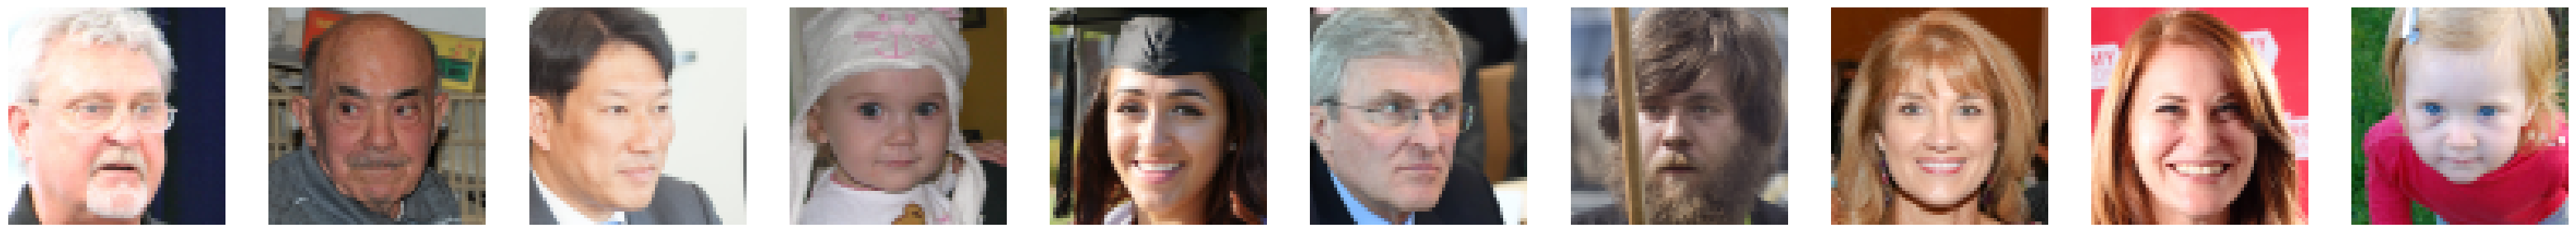

In [4]:
dataset_path = 'FFHQ'
dataset_files_list = os.listdir(dataset_path)
print(len(dataset_files_list))

row_images=[]
for dataset_file_name in dataset_files_list[:10]:
        image=cv2.imread(os.path.join(dataset_path, dataset_file_name), cv2.IMREAD_COLOR)
        image = cv2.resize(image, (64,64), interpolation = cv2.INTER_AREA)
        row_images.append(image)
        
row_images = np.array(row_images)
row_images = row_images.astype('int')

row_images = row_images/127.5-1
# row_images = np.double(row_images)

X_train_r = row_images[:,:,:,2]
X_train_g = row_images[:,:,:,1]
X_train_b = row_images[:,:,:,0]

row_images = np.stack([X_train_r,X_train_g,X_train_b],3)

plt.figure(figsize=(40, 200))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow((row_images[i, :, :, :]+1)/2)
    plt.axis('off')
plt.show()

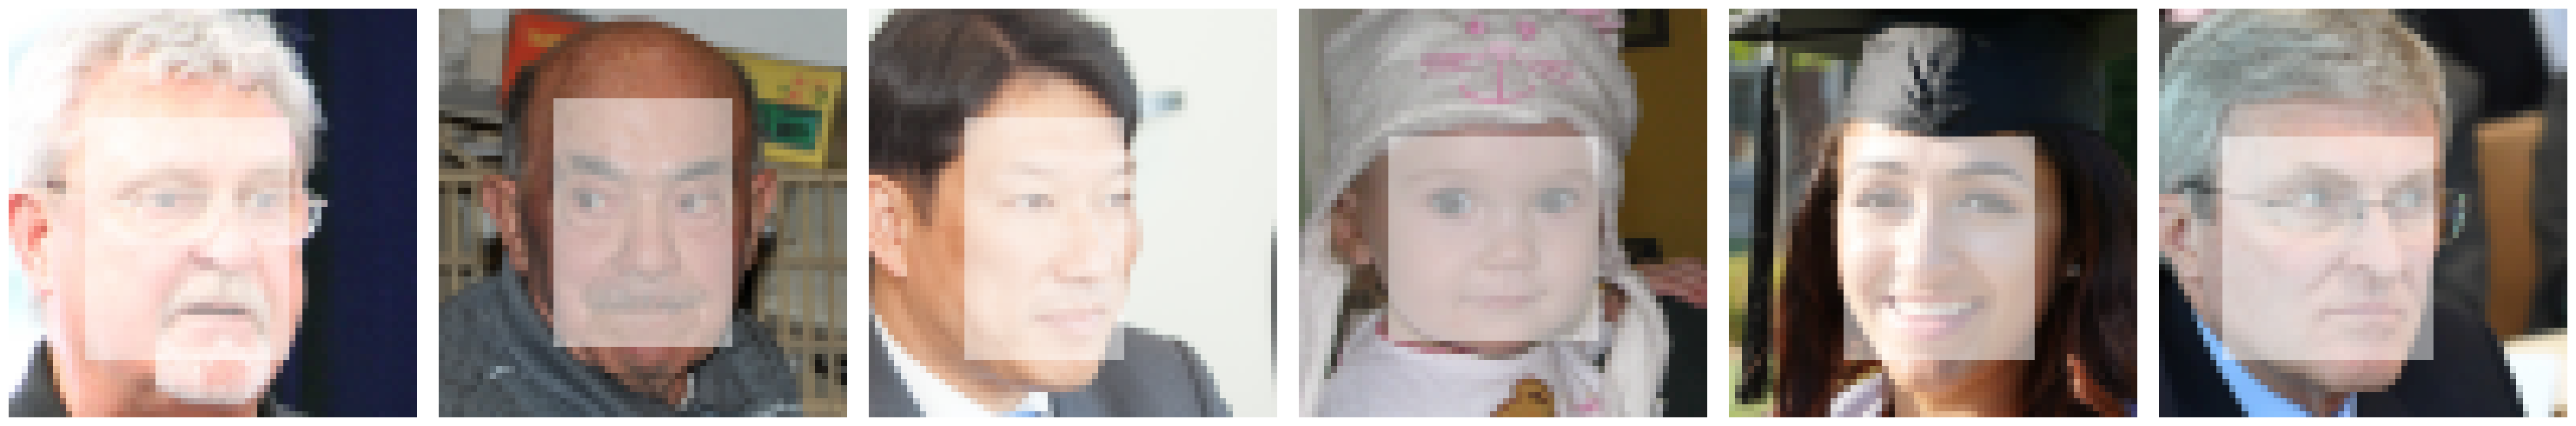

In [5]:
masked_images = []
masks = []
bbs = [[17,55,12,44], [14,53,18,46], [17,55,15,40], [20,52,14,47], [20,55,18,48], [20,55,10,43]]
for i, bb in enumerate(bbs):
    masked_image = row_images[i, :, :, :].copy()
    mask = np.zeros_like(masked_image)
    masked_image[bb[0]:bb[1], bb[2]:bb[3], :] = (masked_image[bb[0]:bb[1], bb[2]:bb[3], :]+1)/2
    mask[bb[0]:bb[1], bb[2]:bb[3], :] = 1
    masked_images.append(masked_image)
    masks.append(mask)
plt.figure(figsize=(30, 5))
for i in range(len(bbs)):
    plt.subplot(1, len(bbs), i+1)
    plt.imshow((masked_images[i]+1)/2)
    plt.axis('off')
plt.tight_layout(h_pad=0, w_pad=0)
plt.show()

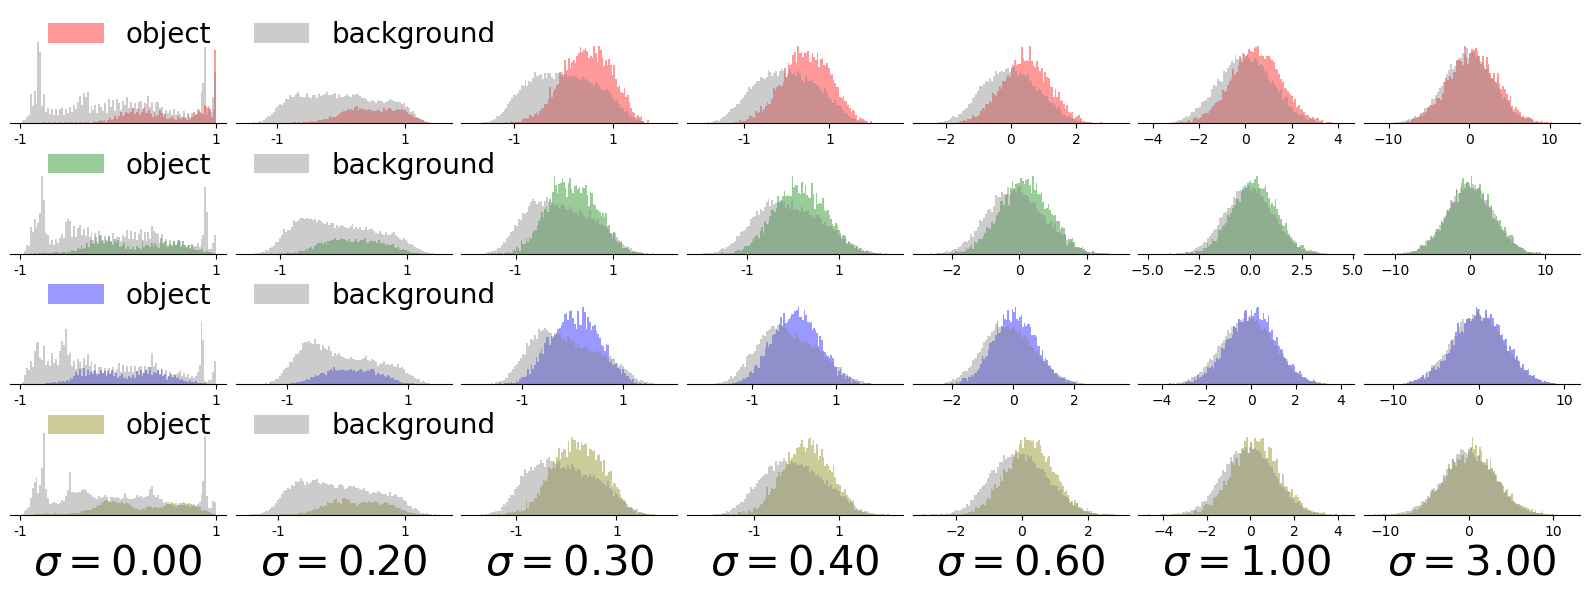

In [46]:
t_steps = [0, 0.2, 0.3, 0.4, 0.6, 1,3]
# fig, axs = plt.figure(figsize=(25, 8))
fig, axs = plt.subplots(4, len(t_steps), figsize=(16, 6))
plt.ioff()
colors = ['red', 'green', 'blue', 'olive']
color_b = 'gray'
colors_b = [color_b,color_b,color_b, 'gray']
masks = []
bbs = [[17,55,12,44], [14,53,18,46], [17,55,15,40], [20,52,14,47], [20,55,18,48], [20,55,10,43]]
for i, bb in enumerate(bbs):
    mask = np.zeros_like(row_images[i, :, :, 0])
    mask[bb[0]:bb[1], bb[2]:bb[3]] = 1
    masks.append(mask)

for color_channel in range(4):
    if color_channel ==3:
        r,g,b = row_images[:6,:,:,0], row_images[:6,:,:,1], row_images[:6,:,:,2]
        checking_image_values = 0.2989 * r + 0.5870 * g + 0.1140 * b
        checking_image_values = checking_image_values.flatten()
    else:
        checking_image_values = row_images[:6,:,:,color_channel].flatten()
    mask_flatten = np.asarray(masks).flatten()

    feature_map = []
    background_map = []
    for i in range(mask_flatten.shape[0]):
        if mask_flatten[i]==1:
            feature_map.append(i)
        elif mask_flatten[i]==0:
            background_map.append(i)
            
    list_of_flatten = [checking_image_values]
    list_of_feature = [checking_image_values[feature_map]]
    list_of_background = [checking_image_values[background_map]]

    for i, t_cur in enumerate(t_steps[1:]):
        checking_images = checking_image_values + (t_cur) * np.random.randn(*checking_image_values.shape)
        list_of_flatten.append(checking_images)
        list_of_feature.append(checking_images[feature_map])
        list_of_background.append(checking_images[background_map])
    num_bins = 100
    alpha = 0.4
    for t in range(len(t_steps)):
        plt.subplot(4, len(t_steps), t+1+color_channel*len(t_steps))
        title = r'$\sigma=$'+ f'%.2f'%t_steps[t]
        if color_channel == 3:
            plt.xlabel(title, loc= 'center',fontsize = 30)
            # plt.title(title, fontsize = 30)
        if t ==0:
            plt.hist(list_of_feature[t], num_bins, density = False , color= colors[color_channel],label = 'object', alpha=alpha)
            plt.hist(list_of_background[t], num_bins, density = False, color= colors_b[color_channel],label = 'background', alpha=alpha)
        elif t ==1:
            plt.hist(list_of_feature[t], num_bins, density = False , color= colors[color_channel],label = 'object', alpha=alpha)
            plt.hist(list_of_background[t], num_bins, density = False, color= colors_b[color_channel],label = 'background', alpha=alpha)
        else:
            plt.hist(list_of_feature[t], num_bins, density = True , color= colors[color_channel],label = 'object', alpha=alpha)

            plt.hist(list_of_background[t], num_bins, density = True, color= colors_b[color_channel],label = 'background', alpha=alpha)
        
        # plt.ylabel('density') 
        plt.yticks([]) 
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        if t <=3:
            plt.xticks([-1,1],['-1','1']) 

        if t ==0:
            bb = (fig.subplotpars.left, fig.subplotpars.top-0.1, 
            fig.subplotpars.right-fig.subplotpars.left+1.4,.1)
            axs[color_channel,0].legend(bbox_to_anchor=bb, mode="expand", loc="lower left",
               ncol=10, borderaxespad=0, prop = { "size": 20 }, frameon=False)
        
        axs[color_channel,1].set_zorder(-1)
        if t <=1:
            # plt.ylim(0, 3)
            plt.ylim(0, 800)

# bb = (fig.subplotpars.left+0.1, fig.subplotpars.top+0.02, 
#       fig.subplotpars.right-fig.subplotpars.left-0.2,.1)
# axs[3,2].legend(bbox_to_anchor=bb, mode="expand", loc="lower left",
#                ncol=10, borderaxespad=0, bbox_transform=fig.transFigure)

plt.tight_layout(h_pad=-0.2, w_pad=0)
plt.show()

In [150]:
color_channel = 2
t_steps = [0, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 1, 1.2, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6, 7, 8, 9, 10, 11, 12]
# t_steps = [0, 0.02, 0.2, 0.4, 0.6, 0.8, 1, 3.0, 6.0, 10]

# checking_image_values = row_images.flatten()
row_images_normalized = (row_images+1)/2
r,g,b = row_images_normalized[:6,:,:,0], row_images_normalized[:6,:,:,1], row_images_normalized[:6,:,:,2]
row_images_normalized = 0.2989 * r + 0.5870 * g + 0.1140 * b
row_images_normalized = row_images_normalized*2-1
checking_image_values = checking_image_values.flatten()

mask_flatten = np.asarray(masks).flatten()

feature_map = []
background_map = []
for i in range(mask_flatten.shape[0]):
    if mask_flatten[i]==1:
        feature_map.append(i)
    elif mask_flatten[i]==0:
        background_map.append(i)
        
list_of_flatten = [checking_image_values.flatten()]
list_of_feature = [checking_image_values.flatten()[feature_map]]
list_of_background = [checking_image_values.flatten()[background_map]]

list_of_kld = [KL(checking_image_values.flatten()[feature_map], checking_image_values.flatten()[background_map])]
list_of_shapiro = [shapiro(checking_image_values.flatten()[feature_map]).pvalue]

for i, t_cur in enumerate(t_steps[1:]):
    checking_images = checking_image_values + (t_cur) * np.random.randn(*checking_image_values.shape)
    list_of_flatten.append(checking_images.flatten())
    list_of_feature.append(checking_images.flatten()[feature_map])
    list_of_background.append(checking_images.flatten()[background_map])
    list_of_kld.append(KL(checking_images.flatten()[feature_map], checking_images.flatten()[background_map]))      
    list_of_shapiro.append(shapiro(checking_images.flatten()[feature_map]).pvalue) 

list_of_shapiro = np.asarray(list_of_shapiro)

print(list_of_shapiro)
print(list_of_shapiro.shape)
print(list_of_kld)
num_bins = 100

[5.62554654e-36 6.46491983e-18 2.12816350e-13 8.15201862e-09
 1.05877174e-03 1.33948357e-04 2.19627749e-02 6.35014996e-02
 9.76336062e-01 7.95782954e-02 4.99427408e-01 2.04318136e-01
 4.84739810e-01 4.18209970e-01 1.35240659e-01 4.13322449e-01
 1.35151548e-02 5.66475987e-01 2.77308285e-01 1.52138233e-01
 9.32229817e-01 4.33562696e-01 4.63010401e-01 9.83252704e-01]
(24,)
[-0.12617054660361476, -0.11489261339872159, -0.10982494139213206, -0.10679132670442149, -0.08584709098338311, -0.09078131048233073, -0.060453770948048435, -0.05561518356626288, -0.03527267098036946, -0.02607453690495648, -0.0072866889646991395, -0.017377687942269182, -0.014829647354112185, -0.019276476184563407, -0.0032751303524711783, -0.004312551266763831, -0.0071533718047405714, 0.02114344090277287, -0.003617971530288866, 0.005318339567415897, 0.004642558768946814, -0.0039561011464108176, 0.00401642511284428, -0.009861338429832445]


/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [151]:
2.19627749e-02 -0.01

0.011962774899999999

In [4]:
class EMAHelper(object):
    """read about EMA
    exponential moving average (EMA) of model weights
    """
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        if isinstance(module,torch.nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        if isinstance(module,torch.nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (
                    1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        if isinstance(module,torch.nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        if isinstance(module,torch.nn.DataParallel):
            inner_module = module.module
            module_copy = type(inner_module)(
                inner_module.config).to(inner_module.config.device)
            module_copy.load_state_dict(inner_module.state_dict())
            module_copy =torch.nn.DataParallel(module_copy, inner_module.args.dataparallel)
        else:
            module_copy = type(module)(module.config).to(module.config.device)
            module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

def get_optimizer(config, parameters):
    if config.optim.optimizer == 'Adam':
        return optim.Adam(parameters, lr=config.optim.lr, weight_decay=config.optim.weight_decay,
                          betas=(config.optim.beta1, 0.999), amsgrad=config.optim.amsgrad,
                          eps=config.optim.eps)
    elif config.optim.optimizer == 'RMSProp':
        return optim.RMSprop(parameters, lr=config.optim.lr, weight_decay=config.optim.weight_decay)
    elif config.optim.optimizer == 'SGD':
        return optim.SGD(parameters, lr=config.optim.lr, momentum=0.9)
    else:
        raise NotImplementedError(
            'Optimizer {} not understood.'.format(config.optim.optimizer))
    
def noise_estimation_loss(net, images, labels=None, augment_pipe=None):
    rnd_normal = torch.randn([images.shape[0],], device=images.device)
    P_mean = np.log(args.sigma_start*args.sigma_end)/2
    P_std = np.log(args.sigma_start/args.sigma_end)/2
    sigma = (rnd_normal * P_std + P_mean).exp()
    reshaped_sigma = sigma.reshape(images.shape[0], 1, 1, 1)
    y = images
    n = torch.randn_like(y) * reshaped_sigma
    D_yn = net(y + n, sigma)
    loss = ((D_yn - y) ** 2)
    return loss.mean()

In [5]:
class Diffusion(object):
    def __init__(self, args, config, device=None
                ):
        self.args = args
        self.config = config
        self.sigma_min = args.sigma_end **2 /args.sigma_start
        self.sigma_max = args.sigma_start **2 /args.sigma_end
        self.rho = 5
        self.loss_his = []
        self.val_loss_his = []
        self.val_loss_steps = []
        self.P_mean = np.log(args.sigma_start*args.sigma_end)/2
        self.P_std = np.log(args.sigma_start/args.sigma_end)/2
        
        if device is None:
            device = (
                self.config.device
                if torch.cuda.is_available()
                else torch.device("cpu")
            )
        self.device = device
        self.num_timesteps = config.diffusion.num_diffusion_timesteps
            
    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)
    
    def train(self):
        print(self.sigma_max)
        print(self.sigma_min)
        args, config = self.args, self.config
        tb_logger = self.config.tb_logger
        dataset = train_images_tensor
        val_dataset = val_images_tensor[:config.training.batch_size]
#         val_dataset = val_images_tensor
        train_loader = data.DataLoader(
            dataset,
            batch_size=config.training.batch_size,
            shuffle=True,
            num_workers=config.data.num_workers,
        )
        model = Model(config)

        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Number of parameters in the model: {total_params}")
        
        model = model.to(self.device)
        model = torch.nn.DataParallel(model,self.args.dataparallel)

        optimizer = get_optimizer(self.config, model.parameters())

        if self.config.model.ema:
            ema_helper = EMAHelper(mu=self.config.model.ema_rate)
            ema_helper.register(model)
        else:
            ema_helper = None

        start_epoch, step = 0, 0
        if self.args.resume_training:
            states = torch.load(os.path.join(self.args.log_path, "ckpt.pth"))
            model.load_state_dict(states[0])

            states[1]["param_groups"][0]["eps"] = self.config.optim.eps
            states[1]["param_groups"][0]["lr"] = self.config.optim.lr
            optimizer.load_state_dict(states[1])
            start_epoch = states[2]
            step = states[3]
            if self.config.model.ema:
                ema_helper.load_state_dict(states[4])

        for epoch in range(start_epoch, self.config.training.n_epochs):
            data_start = time.time()
            data_time = 0
            for i, x in enumerate(train_loader):
                data_time += time.time() - data_start
                model.train()
                step += 1
                x = x.to(self.device)
                loss_registry = {'simple': noise_estimation_loss,}

                loss = loss_registry[config.model.type](net = model, images = x)

                print(
                    f"step: {step}, loss: {loss.item()}, data time: {data_time / (i+1)}"
                )

                optimizer.zero_grad()
                loss.backward()

                try:
                    torch.nn.utils.clip_grad_norm_(
                        model.parameters(), config.optim.grad_clip
                    )
                except Exception:
                    pass
                
                optimizer.step()

                if self.config.model.ema:
                    ema_helper.update(model)
                
                data_start = time.time()
            
            if epoch % self.config.training.snapshot_freq == 0 or epoch == 0:
                states = [
                    model.state_dict(),
                    optimizer.state_dict(),
                    epoch,
                    step,
                ]
                if self.config.model.ema:
                    states.append(ema_helper.state_dict())

                torch.save(
                    states,
                    os.path.join(self.args.log_path, "ckpt_{}.pth".format(step)),
                )
                torch.save(states, os.path.join(self.args.log_path, "ckpt.pth"))
                
            if epoch % self.config.training.validation_freq == 0 :   
                model.eval()
                self.sample_sequence(model, training = True, epoch = epoch)
            
            val_dataset = val_dataset.to(self.device)
            val_loss = loss_registry[config.model.type](net = model, images = val_dataset)
            self.val_loss_his = np.append(self.val_loss_his, val_loss.item())
            self.val_loss_steps = np.append(self.val_loss_steps, epoch)
            
            self.loss_his = np.append(self.loss_his,loss.item())
            his_len = [ _ for _ in range(0, len(self.loss_his))]
            plt.figure()
            plt.plot(his_len, self.loss_his, label = "loss")
            plt.plot(self.val_loss_steps, self.val_loss_his, label = "val_loss")
            plt.legend()
            plt.savefig(os.path.join(self.args.log_path, 'loss_his.png'))
            np.save(os.path.join(self.args.log_path, "loss_his.npy"), self.loss_his)

    def sample(self):
        model = Model(self.config)
        if self.args.ckpt_id is None:
            states = torch.load(
                os.path.join(self.args.log_path, "ckpt.pth"),
                map_location=self.config.device,
            )
        else:
            states = torch.load(
                os.path.join(
                    self.args.log_path, f"ckpt_{self.args.ckpt_id}.pth"
                ),
                map_location=self.config.device,
            )
            print('load ckpt: ', self.args.ckpt_id)
            
        model = model.to(self.device)
        model = torch.nn.DataParallel(model, self.args.dataparallel)
#         model = model.to(self.device)
        model.load_state_dict(states[0], strict=True)
        print('load epoch: ', states[3])

        model.eval()

        if self.args.fid:
            self.sample_fid(model)
        elif self.args.interpolation:
            self.sample_interpolation(model)
        elif self.args.sequence:
            self.sample_sequence(model)
        else:
            raise NotImplementedError("Sample procedeure not defined")

    def sample_fid(self, model):
        config = self.config
        img_id = len(glob.glob(f"{self.args.image_folder}/*"))
        print(f"starting from image {img_id}")
        total_n_samples = 300
        n_rounds = (total_n_samples - img_id) // config.sampling.batch_size

        with torch.no_grad():
            for _ in tqdm.tqdm(
                range(n_rounds), desc="Generating image samples for FID evaluation."
            ):
                n = config.sampling.batch_size
                x = torch.randn(
                    n,
                    config.data.channels,
                    config.data.image_size,
                    config.data.image_size,
                    device=self.device,
                )

                x = self.sample_image(x, model)
#                 x = inverse_data_transform(config, x)
                x = [(y + 1.0) / 2.0 for y in x]
                for i in range(n):
                    tvu.save_image(
                        x[i], os.path.join(self.args.image_folder, f"{img_id}.png")
                    )
                    img_id += 1

    def sample_sequence(self, model, training = False, epoch = None):
        config = self.config

        x = torch.randn(
            config.sampling.batch_size,
            config.data.channels,
            config.data.image_size,
            config.data.image_size,
            device=self.device,
        )
        
        data_start = time.time()
        data_time = 0
        # NOTE: This means that we are producing each predicted x0, not x_{t-1} at timestep t.
        with torch.no_grad():
            x = self.sample_image(x, model)
        data_time += time.time() - data_start
        print(f"the sample time of {self.config.sampling.batch_size} images takes {data_time}")

#         x = [inverse_data_transform(config, y) for y in x]
        x = [(y + 1.0) / 2.0 for y in x]
#         if not training:
#             for i in range(len(x)):
#                 for j in range(x[i].size(0)):
#                     tvu.save_image(
#                         x[i][j], os.path.join(self.args.image_folder, f"{step}_{j}_{i}.png")
#                     )
        for i in range(20):
            tvu.save_image(x[i], os.path.join(self.args.image_folder, f"generated_{i}.png"))
        if not training:
            plt.figure(figsize=(40, 8))
            
            for i in range(20):
                plt.ioff()
                plt.subplot(2, 10, i+1)
                img = x[i]
                img = img.permute((1, 2, 0)).numpy()
                # img = (img+1)*2
                plt.imshow(np.asarray(img))
                plt.axis('off')
            plt.savefig(os.path.join(self.args.image_folder, f"generated_image_{self.args.sample_type}_{self.args.skip_type}_{self.args.timesteps}_{data_time}s.png"))  
        
        else:
            plt.figure(figsize=(16, 8))
            
            for i in range(8):
                plt.ioff()
                plt.subplot(2, 4, i+1)
                img = x[i]
                img = img.permute((1, 2, 0)).numpy()
                # img = (img+1)*2
                plt.imshow(np.asarray(img))
                plt.axis('off')
            plt.savefig(os.path.join(self.args.image_folder, f"{epoch}.png"))
            
#             tvu.save_image(
#                         x[999,:,:,:,:], os.path.join(self.args.image_folder, f"{step}.png")
#                     )

    def sample_interpolation(self, model):
        config = self.config

        test_dataset = test_images_tensor 
        test_dataset = test_dataset.to(self.device)
        
        def slerp(z1, z2, alpha):
            theta = torch.acos(torch.sum(z1 * z2) / (torch.norm(z1) * torch.norm(z2)))
            return (
                torch.sin((1 - alpha) * theta) / torch.sin(theta) * z1
                + torch.sin(alpha * theta) / torch.sin(theta) * z2
            )
        x1 = test_dataset[:1]
        x2 = test_dataset[7:8]

        tvu.save_image(x1, os.path.join(self.args.generated_image_folder, f"source_1.png"))
        tvu.save_image(x2, os.path.join(self.args.generated_image_folder, f"source_2.png"))
        
         # Time step discretization.
        step_indices = torch.arange(self.args.timesteps, device=self.device)
        t_steps = (self.sigma_max ** (1 / self.rho) + step_indices / (self.args.timesteps - 1) * (self.sigma_min ** (1 / self.rho) - self.sigma_max ** (1 / self.rho))) ** self.rho
        t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
        t_steps = t_steps.flip(0)
        
        z1 = x1
        z2 = x2
        
        for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
            z1 = z1 + (t_next-t_cur) * torch.randn_like(z1)
            z2 = z2 + (t_next-t_cur) * torch.randn_like(z2)
        
        z1 = z1/80
        z2 = z2/80
        
        alpha = torch.arange(0.0, 1.01, 0.1).to(z1.device)
        z_ = []
        for i in range(alpha.size(0)):
            z_.append(slerp(z1, z2, alpha[i]))

        x = torch.cat(z_, dim=0)
        xs = []

        # Hard coded here, modify to your preferences
        with torch.no_grad():
            for i in range(0, x.size(0), 8):
                xs.append(self.sample_image(x[i : i + 8], model))
#         x = inverse_data_transform(config, torch.cat(xs, dim=0))
        x = [(y + 1.0) / 2.0 for y in torch.cat(xs, dim=0)]
        for i in range(len(x)):
            tvu.save_image(x[i], os.path.join(self.args.generated_image_folder, f"{i}.png"))

    def sample_image(self, x, model):
        
        
        data_start = time.time()
        data_time = 0
        if self.args.sample_type == "deterministic":
             x = edm_sampler(latents = x, num_steps = self.args.timesteps, net = model, randn_like=torch.randn_like, sigma_min = self.sigma_min, sigma_max = self.sigma_max )
        elif self.args.sample_type == "stochastic":
             x = edm_sampler(latents = x, num_steps = self.args.timesteps, net = model, randn_like=torch.randn_like, sigma_min = self.sigma_min, sigma_max = self.sigma_max, S_churn=5, S_min= 0, S_max=1000, S_noise=1.003)
        else:
            raise NotImplementedError
        return x
        data_time += time.time() - data_start
        print(data_time)
        
    def test(self):
        pass


In [6]:
def edm_sampler(
    latents, num_steps, net,  class_labels=None, randn_like=torch.randn_like, sigma_min=0.002, sigma_max=80, rho=5,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1
):
    
    # Time step discretization.
    step_indices = torch.arange(num_steps, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = [latents * t_steps[0]]
#     x_next = [latents]
    print(t_steps)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        
        t_cur = torch.ones(x_next[0].shape[0], device=t_cur.device) * t_cur
        t_next = torch.ones(x_next[0].shape[0], device=t_next.device) * t_next
        
        x_cur = x_next[-1]

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur[0] <= S_max else 0
        t_hat = torch.as_tensor(t_cur + gamma * t_cur)
        x_hat = (x_cur + (t_hat[0] ** 2 - t_cur[0] ** 2).sqrt() * S_noise * randn_like(x_cur))
        
        # Euler step.
#         denoised = net(x_hat, t_hat, class_labels).to(torch.float64)
        denoised = net(x_hat, t_hat)
        d_cur = (x_hat - denoised) / t_hat[0]
        x_next_ = x_hat + (t_next[0] - t_hat[0]) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next_, t_next)
#             denoised = net(x_next_, t_next, class_labels)
            d_prime = (x_next_ - denoised) / t_next[0]
            x_next_ = x_hat + (t_next[0] - t_hat[0]) * (0.5 * d_cur + 0.5 * d_prime)
        
        x_next.append(x_next_)
        
#         for i, _x_next in enumerate(x_next):
#             tvu.save_image(_x_next, os.path.join("18steps_generation_process", f"generated_step_{i}.png"))
        
    return x_next[-1].cpu()

In [7]:
torch.set_printoptions(sci_mode=False)
args = {
    'config': 'FFHQ_64.yml',
    'seed': 1234,
    'exp': 'result_diffusion_model',
    'doc': 'log_folder',
    'comment': "",
    'verbose': "info",
    'sequence': False,
    'test': False,
    'sample': False,
    'fid': False,
    'interpolation': False,
    'resume_training': True,
    'image_folder': "result_diffusion_model/images",
    # 'generated_image_folder': "SDM_iterative_noise_best",
    'ni': False,
    'use_pretrained': False,
    'sample_type': "stochastic",
#     deterministic, stochastic
    'timesteps': 18,
    'eta': 0.0,
    'dataparallel': [0],
    # 'ckpt_id': '196000',
    'rho' : 7,
#     'skip': 500,
    'sigma_start' : 8,
    'sigma_end' : 0.8,
    
}

args['log_path']=os.path.join(args['exp'], "logs", args['doc'])
args = dict2namespace(args)
with open(args.config, "r") as f:
    config = yaml.safe_load(f)
config['tb_logger'] = None
config = dict2namespace(config)
tb_path = os.path.join(args.exp, "tensorboard", args.doc)

(10000, 64, 64, 3)
train image data range: { -1.0 ~ 1.0 }
(1000, 64, 64, 3)
train image data range: { -1.0 ~ 1.0 }


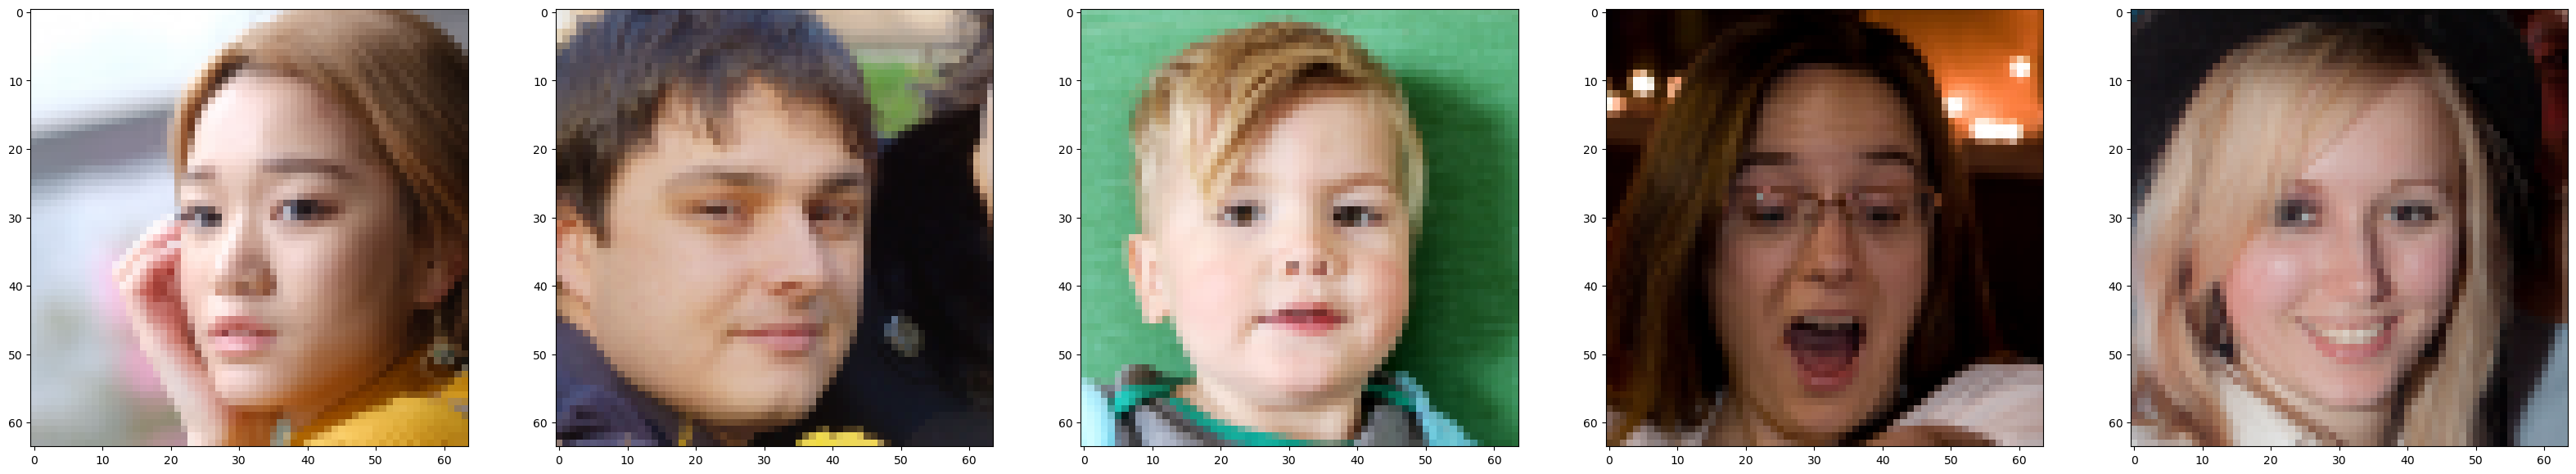

In [8]:
if not args.test and not args.sample:
    train_images = np.load('FFHQ_train_64_10k.npy', mmap_mode='r')
    val_images = np.load('FFHQ_val_64.npy', mmap_mode='r')
    train_images = train_images/0.5-1
    val_images = val_images/0.5-1
    print(train_images.shape)
    print("train image data range: {", train_images[:100].min(),"~",train_images[:100].max(),"}")
    print(val_images.shape)
    print("train image data range: {", val_images.min(),"~",val_images.max(),"}")
    train_images_tensor = torch.tensor(train_images).float()
    train_images_tensor = train_images_tensor.permute((0, 3, 1, 2))
    val_images_tensor = torch.tensor(val_images).float()
    val_images_tensor = val_images_tensor.permute((0,3, 1, 2))
    plotting_images = (train_images+1)*0.5
    del train_images

else:
    test_images = np.load('../PoDM_chair_128/chair_train_128_s.npy', mmap_mode='r')
    test_images = test_images/0.5-1
    test_images_tensor = torch.tensor(test_images)
    test_images_tensor = test_images_tensor.permute((0,3, 1, 2))
    plotting_images = test_images
    del test_images

plt.figure(figsize=(40, 200))
plt.subplot(1, 5, 1)
plt.imshow(plotting_images[0, :, :])
plt.subplot(1, 5, 2)
plt.imshow(plotting_images[5, :, :])
plt.subplot(1, 5, 3)
plt.imshow(plotting_images[6, :, :])
plt.subplot(1, 5, 4)
plt.imshow(plotting_images[7, :, :])
plt.subplot(1, 5, 5)
plt.imshow(plotting_images[8, :, :])

In [9]:
for i in [0,5,6,7,8]:
    tvu.save_image(torch.tensor(plotting_images[i]).permute((2, 0, 1)), f"test_{i}.png")

In [10]:
torch_device = "cuda:" + str(args.dataparallel[0])
device = torch.device(torch_device) if torch.cuda.is_available() else torch.device("cpu")
print("Using device: {}".format(device))
config.device = device

# set random seed
torch.manual_seed(args.seed)
np.random.seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

torch.backends.cudnn.benchmark = True

if not args.test and not args.sample:
    if not args.resume_training:
        if os.path.exists(args.log_path):
            overwrite = False
            if args.ni:
                overwrite = True
            if overwrite:
                shutil.rmtree(args.log_path)
                os.makedirs(args.log_path)
                if os.path.exists(tb_path):
                    shutil.rmtree(tb_path)
            else:
                print("Folder exists. Program halted.")
        else:
            os.makedirs(args.log_path)
        
        if os.path.exists(args.image_folder):
            if args.ni:
                overwrite = True
            if overwrite:
                shutil.rmtree(args.image_folder)
                os.makedirs(args.image_folder)
            else:
                print("Folder exists. Program halted.")
        else:
            os.makedirs(args.image_folder)

        with open(os.path.join(args.log_path, "config.yml"), "w") as f:
            yaml.dump(config, f, default_flow_style=False)

Using device: cuda:0


In [ ]:
runner = Diffusion(args, config, config.device)
# runner.sample()
# runner.test()
runner.train()

80.0
0.08000000000000002
Number of parameters in the model: 1525411
step: 675706, loss: 0.0629381388425827, data time: 0.13767337799072266
step: 675707, loss: 0.06726555526256561, data time: 0.0696946382522583
step: 675708, loss: 0.06706247478723526, data time: 0.04705047607421875
step: 675709, loss: 0.06343020498752594, data time: 0.03606313467025757
step: 675710, loss: 0.06904904544353485, data time: 0.029201793670654296
step: 675711, loss: 0.05826302617788315, data time: 0.024611234664916992
step: 675712, loss: 0.06725192070007324, data time: 0.021351235253470286
step: 675713, loss: 0.06534653156995773, data time: 0.01898530125617981
step: 675714, loss: 0.05909223482012749, data time: 0.01713903745015462
step: 675715, loss: 0.0664842277765274, data time: 0.015662074089050293
step: 675716, loss: 0.06267265230417252, data time: 0.01446357640353116
step: 675717, loss: 0.06819504499435425, data time: 0.013463775316874186
step: 675718, loss: 0.06079743430018425, data time: 0.012625987713

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 675746, loss: 0.06002487987279892, data time: 0.12861919403076172
step: 675747, loss: 0.056587398052215576, data time: 0.06640315055847168
step: 675748, loss: 0.06120461970567703, data time: 0.044711033503214516
step: 675749, loss: 0.06128303334116936, data time: 0.03414982557296753
step: 675750, loss: 0.06205202266573906, data time: 0.027571439743041992
step: 675751, loss: 0.06686960160732269, data time: 0.02320249875386556
step: 675752, loss: 0.06331866979598999, data time: 0.020088604518345425
step: 675753, loss: 0.0646083876490593, data time: 0.017826944589614868
step: 675754, loss: 0.06647607684135437, data time: 0.015984747144911025
step: 675755, loss: 0.06272748857736588, data time: 0.014580345153808594
step: 675756, loss: 0.06426536291837692, data time: 0.013438658280806108
step: 675757, loss: 0.05611374229192734, data time: 0.012484471003214518
step: 675758, loss: 0.06452152132987976, data time: 0.011684894561767578
step: 675759, loss: 0.06308083981275558, data time: 0.0

/tmp/ipykernel_1585/3775808921.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


step: 676506, loss: 0.06542713940143585, data time: 0.1530437469482422
step: 676507, loss: 0.06089073419570923, data time: 0.07727503776550293
step: 676508, loss: 0.06147067993879318, data time: 0.0520174503326416
step: 676509, loss: 0.06498103588819504, data time: 0.039941489696502686
step: 676510, loss: 0.0638437420129776, data time: 0.032282686233520506
step: 676511, loss: 0.06380265951156616, data time: 0.02716680367787679
step: 676512, loss: 0.06284940242767334, data time: 0.023547989981515065
step: 676513, loss: 0.06526368856430054, data time: 0.020901262760162354
step: 676514, loss: 0.05701621621847153, data time: 0.018757237328423396
step: 676515, loss: 0.06151486933231354, data time: 0.01711721420288086
step: 676516, loss: 0.06503038853406906, data time: 0.01579217477278276
step: 676517, loss: 0.06047624349594116, data time: 0.014681736628214518
step: 676518, loss: 0.0578623041510582, data time: 0.013734065569364108
step: 676519, loss: 0.06431950628757477, data time: 0.0129225

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 676546, loss: 0.06609033048152924, data time: 0.1676795482635498
step: 676547, loss: 0.06420034170150757, data time: 0.08519017696380615
step: 676548, loss: 0.0588192492723465, data time: 0.057657082875569664
step: 676549, loss: 0.06332613527774811, data time: 0.04398345947265625
step: 676550, loss: 0.06606119871139526, data time: 0.03547005653381348
step: 676551, loss: 0.06259283423423767, data time: 0.029778162638346355
step: 676552, loss: 0.0567590594291687, data time: 0.0257155214037214
step: 676553, loss: 0.06814844906330109, data time: 0.022751539945602417
step: 676554, loss: 0.061830248683691025, data time: 0.020367225011189777
step: 676555, loss: 0.06697158515453339, data time: 0.018520641326904296
step: 676556, loss: 0.05413498729467392, data time: 0.01701886003667658
step: 676557, loss: 0.05915239453315735, data time: 0.015768508116404217
step: 676558, loss: 0.06513440608978271, data time: 0.014719009399414062
step: 676559, loss: 0.06367479264736176, data time: 0.013806

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 677346, loss: 0.0606670044362545, data time: 0.1492443084716797
step: 677347, loss: 0.05876324698328972, data time: 0.07646369934082031
step: 677348, loss: 0.061556361615657806, data time: 0.05151589711507162
step: 677349, loss: 0.058936964720487595, data time: 0.03942227363586426
step: 677350, loss: 0.06200053542852402, data time: 0.03180389404296875
step: 677351, loss: 0.06340433657169342, data time: 0.026750922203063965
step: 677352, loss: 0.06053696200251579, data time: 0.023129429136003767
step: 677353, loss: 0.061497896909713745, data time: 0.020542889833450317
step: 677354, loss: 0.06563620269298553, data time: 0.018405755360921223
step: 677355, loss: 0.057111870497465134, data time: 0.016770148277282716
step: 677356, loss: 0.06272599846124649, data time: 0.015441764484752308
step: 677357, loss: 0.06235728785395622, data time: 0.014337380727132162
step: 677358, loss: 0.06077728793025017, data time: 0.01341555668757512
step: 677359, loss: 0.05961717665195465, data time: 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 678146, loss: 0.0564994215965271, data time: 0.1629633903503418
step: 678147, loss: 0.06223207712173462, data time: 0.08304882049560547
step: 678148, loss: 0.0582767128944397, data time: 0.05588142077128092
step: 678149, loss: 0.06003851816058159, data time: 0.04276317358016968
step: 678150, loss: 0.06126003712415695, data time: 0.03449668884277344
step: 678151, loss: 0.061379607766866684, data time: 0.028974135716756184
step: 678152, loss: 0.058778055012226105, data time: 0.02503861699785505
step: 678153, loss: 0.051595836877822876, data time: 0.022158056497573853
step: 678154, loss: 0.06296254694461823, data time: 0.019847181108262803
step: 678155, loss: 0.05837615579366684, data time: 0.01805415153503418
step: 678156, loss: 0.06384392082691193, data time: 0.016625751148570667
step: 678157, loss: 0.059750091284513474, data time: 0.015412092208862305
step: 678158, loss: 0.0575106106698513, data time: 0.014388781327467699
step: 678159, loss: 0.06359733641147614, data time: 0.0135

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 678946, loss: 0.06198719143867493, data time: 0.1711561679840088
step: 678947, loss: 0.06297548860311508, data time: 0.08697021007537842
step: 678948, loss: 0.06463517248630524, data time: 0.05903871854146322
step: 678949, loss: 0.06473414599895477, data time: 0.04497098922729492
step: 678950, loss: 0.06279145181179047, data time: 0.03625059127807617
step: 678951, loss: 0.06493528187274933, data time: 0.03046262264251709
step: 678952, loss: 0.05912159010767937, data time: 0.02630720819745745
step: 678953, loss: 0.06593553721904755, data time: 0.023274600505828857
step: 678954, loss: 0.06393687427043915, data time: 0.020836220847235784
step: 678955, loss: 0.06510508060455322, data time: 0.018966364860534667
step: 678956, loss: 0.05816800519824028, data time: 0.017435962503606624
step: 678957, loss: 0.06395342946052551, data time: 0.016157567501068115
step: 678958, loss: 0.06221110746264458, data time: 0.015081240580632137
step: 678959, loss: 0.0651901364326477, data time: 0.014145

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 679746, loss: 0.06284049153327942, data time: 0.17832446098327637
step: 679747, loss: 0.06393066048622131, data time: 0.09053266048431396
step: 679748, loss: 0.06565412133932114, data time: 0.0613861878712972
step: 679749, loss: 0.06079898774623871, data time: 0.04667884111404419
step: 679750, loss: 0.058440715074539185, data time: 0.03763742446899414
step: 679751, loss: 0.06161315366625786, data time: 0.03161243597666422
step: 679752, loss: 0.0623682364821434, data time: 0.027308293751307895
step: 679753, loss: 0.05687183886766434, data time: 0.02414083480834961
step: 679754, loss: 0.061058949679136276, data time: 0.02160440550910102
step: 679755, loss: 0.060553789138793945, data time: 0.019641304016113283
step: 679756, loss: 0.06518791615962982, data time: 0.01804772290316495
step: 679757, loss: 0.06527353823184967, data time: 0.01672796408335368
step: 679758, loss: 0.059192758053541183, data time: 0.015596353090726413
step: 679759, loss: 0.05939801037311554, data time: 0.01462

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 680546, loss: 0.0577341690659523, data time: 0.17917084693908691
step: 680547, loss: 0.06081031262874603, data time: 0.09089434146881104
step: 680548, loss: 0.06664034724235535, data time: 0.06120077768961588
step: 680549, loss: 0.06980681419372559, data time: 0.04684656858444214
step: 680550, loss: 0.06304341554641724, data time: 0.037793207168579104
step: 680551, loss: 0.064421147108078, data time: 0.03177460034688314
step: 680552, loss: 0.059084512293338776, data time: 0.027482543672834123
step: 680553, loss: 0.061590127646923065, data time: 0.024350225925445557
step: 680554, loss: 0.0671626552939415, data time: 0.021814664204915363
step: 680555, loss: 0.06314477324485779, data time: 0.019859504699707032
step: 680556, loss: 0.057604458183050156, data time: 0.018281329761851917
step: 680557, loss: 0.06665515154600143, data time: 0.016960124174753826
step: 680558, loss: 0.0622236542403698, data time: 0.015847297815176156
step: 680559, loss: 0.06447772681713104, data time: 0.0148

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 681346, loss: 0.06336934864521027, data time: 0.18875503540039062
step: 681347, loss: 0.06342142075300217, data time: 0.09515202045440674
step: 681348, loss: 0.05746377259492874, data time: 0.06395689646402995
step: 681349, loss: 0.06221681088209152, data time: 0.048887550830841064
step: 681350, loss: 0.05995657294988632, data time: 0.03939309120178223
step: 681351, loss: 0.057909123599529266, data time: 0.033073862393697105
step: 681352, loss: 0.06638994067907333, data time: 0.028569698333740234
step: 681353, loss: 0.06391417235136032, data time: 0.025260448455810547
step: 681354, loss: 0.06667548418045044, data time: 0.022600730260213215
step: 681355, loss: 0.06090294569730759, data time: 0.020548200607299803
step: 681356, loss: 0.06408762186765671, data time: 0.018883011557839134
step: 681357, loss: 0.0624331459403038, data time: 0.0174940824508667
step: 681358, loss: 0.06046510487794876, data time: 0.016314873328575723
step: 681359, loss: 0.061181604862213135, data time: 0.01

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 682146, loss: 0.0678999125957489, data time: 0.18549752235412598
step: 682147, loss: 0.056536994874477386, data time: 0.0935060977935791
step: 682148, loss: 0.06308978796005249, data time: 0.06353076299031575
step: 682149, loss: 0.05432648956775665, data time: 0.04832935333251953
step: 682150, loss: 0.06415939331054688, data time: 0.03894267082214355
step: 682151, loss: 0.06555147469043732, data time: 0.03269430001576742
step: 682152, loss: 0.06333232671022415, data time: 0.028278725487845286
step: 682153, loss: 0.06479291617870331, data time: 0.02498719096183777
step: 682154, loss: 0.06585418432950974, data time: 0.022354099485609267
step: 682155, loss: 0.05754096433520317, data time: 0.020316243171691895
step: 682156, loss: 0.0666259229183197, data time: 0.018672943115234375
step: 682157, loss: 0.057564876973629, data time: 0.01729889710744222
step: 682158, loss: 0.06279581785202026, data time: 0.016131089283869818
step: 682159, loss: 0.05924306437373161, data time: 0.015126143

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 682946, loss: 0.06099739670753479, data time: 0.19125080108642578
step: 682947, loss: 0.06649458408355713, data time: 0.0971759557723999
step: 682948, loss: 0.06346185505390167, data time: 0.06530563036600749
step: 682949, loss: 0.05788911506533623, data time: 0.04986530542373657
step: 682950, loss: 0.0626404881477356, data time: 0.040194368362426756
step: 682951, loss: 0.06165074557065964, data time: 0.03377751509348551
step: 682952, loss: 0.05486826226115227, data time: 0.029187985828944614
step: 682953, loss: 0.05753042548894882, data time: 0.02583983540534973
step: 682954, loss: 0.05907731503248215, data time: 0.023148669136895075
step: 682955, loss: 0.06376545131206512, data time: 0.02106454372406006
step: 682956, loss: 0.0600569061934948, data time: 0.019386226480657406
step: 682957, loss: 0.060527559369802475, data time: 0.017989555994669598
step: 682958, loss: 0.054436974227428436, data time: 0.016809885318462666
step: 682959, loss: 0.061208516359329224, data time: 0.0157

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 683746, loss: 0.05579938739538193, data time: 0.2030162811279297
step: 683747, loss: 0.061610788106918335, data time: 0.10230875015258789
step: 683748, loss: 0.06345440447330475, data time: 0.06874489784240723
step: 683749, loss: 0.06212472915649414, data time: 0.05242276191711426
step: 683750, loss: 0.06524163484573364, data time: 0.04222254753112793
step: 683751, loss: 0.06002695485949516, data time: 0.03542105356852213
step: 683752, loss: 0.05959886312484741, data time: 0.03055971009390695
step: 683753, loss: 0.06761743128299713, data time: 0.027000606060028076
step: 683754, loss: 0.05563031882047653, data time: 0.024146768781873915
step: 683755, loss: 0.06523447483778, data time: 0.021929454803466798
step: 683756, loss: 0.0600910410284996, data time: 0.020129268819635563
step: 683757, loss: 0.06739895790815353, data time: 0.018632312615712483
step: 683758, loss: 0.06239078938961029, data time: 0.017360944014329176
step: 683759, loss: 0.06383152306079865, data time: 0.01626488

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 684546, loss: 0.05912887305021286, data time: 0.20749878883361816
step: 684547, loss: 0.0606495700776577, data time: 0.10449004173278809
step: 684548, loss: 0.06153886020183563, data time: 0.07017882664998372
step: 684549, loss: 0.05953648313879967, data time: 0.05351895093917847
step: 684550, loss: 0.059431515634059906, data time: 0.043076515197753906
step: 684551, loss: 0.05983445793390274, data time: 0.03613642851511637
step: 684552, loss: 0.06439805030822754, data time: 0.03117537498474121
step: 684553, loss: 0.0628361850976944, data time: 0.027529478073120117
step: 684554, loss: 0.06276822835206985, data time: 0.024617221620347764
step: 684555, loss: 0.06582286208868027, data time: 0.022356843948364256
step: 684556, loss: 0.06619718670845032, data time: 0.020571903748945755
step: 684557, loss: 0.06479261815547943, data time: 0.01906357208887736
step: 684558, loss: 0.06418181210756302, data time: 0.017791069470919095
step: 684559, loss: 0.05999530851840973, data time: 0.01668

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 685346, loss: 0.07034081965684891, data time: 0.21740388870239258
step: 685347, loss: 0.06420508027076721, data time: 0.11013758182525635
step: 685348, loss: 0.06064146012067795, data time: 0.07447600364685059
step: 685349, loss: 0.06499484181404114, data time: 0.05649513006210327
step: 685350, loss: 0.06794893741607666, data time: 0.045512056350708006
step: 685351, loss: 0.061786405742168427, data time: 0.03819835186004639
step: 685352, loss: 0.05256550759077072, data time: 0.03299491746085031
step: 685353, loss: 0.07382657378911972, data time: 0.029161721467971802
step: 685354, loss: 0.0636337473988533, data time: 0.02609162860446506
step: 685355, loss: 0.06548301875591278, data time: 0.023716259002685546
step: 685356, loss: 0.059893399477005005, data time: 0.021793235432017933
step: 685357, loss: 0.0641925260424614, data time: 0.02019015947977702
step: 685358, loss: 0.0678928792476654, data time: 0.018829217323890098
step: 685359, loss: 0.06491158902645111, data time: 0.017648

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 686146, loss: 0.06325143575668335, data time: 0.21282267570495605
step: 686147, loss: 0.05992567539215088, data time: 0.10770547389984131
step: 686148, loss: 0.0599033385515213, data time: 0.07270479202270508
step: 686149, loss: 0.05858250707387924, data time: 0.05534946918487549
step: 686150, loss: 0.06016971915960312, data time: 0.044531822204589844
step: 686151, loss: 0.05924045294523239, data time: 0.03736642996470133
step: 686152, loss: 0.0649334043264389, data time: 0.032225234167916436
step: 686153, loss: 0.06587221473455429, data time: 0.0284574031829834
step: 686154, loss: 0.06831112504005432, data time: 0.025436984168158636
step: 686155, loss: 0.06007577106356621, data time: 0.023090291023254394
step: 686156, loss: 0.06380385160446167, data time: 0.021187002008611507
step: 686157, loss: 0.0645853653550148, data time: 0.0196113387743632
step: 686158, loss: 0.0618862584233284, data time: 0.018259030122023363
step: 686159, loss: 0.062626913189888, data time: 0.017092006547

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 686946, loss: 0.05823011323809624, data time: 0.22661066055297852
step: 686947, loss: 0.0630728155374527, data time: 0.11404836177825928
step: 686948, loss: 0.06292938441038132, data time: 0.0768124262491862
step: 686949, loss: 0.06193699687719345, data time: 0.05847960710525513
step: 686950, loss: 0.059832774102687836, data time: 0.047057151794433594
step: 686951, loss: 0.060240745544433594, data time: 0.03945342699686686
step: 686952, loss: 0.06821621209383011, data time: 0.034019333975655694
step: 686953, loss: 0.055741842836141586, data time: 0.030015498399734497
step: 686954, loss: 0.06864960491657257, data time: 0.026820394727918837
step: 686955, loss: 0.06355404853820801, data time: 0.0243699312210083
step: 686956, loss: 0.06430663168430328, data time: 0.022345326163552025
step: 686957, loss: 0.06765174865722656, data time: 0.020660380522410076
step: 686958, loss: 0.061275482177734375, data time: 0.019231356107271634
step: 686959, loss: 0.060031913220882416, data time: 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 687746, loss: 0.06043412536382675, data time: 0.22345495223999023
step: 687747, loss: 0.0633416622877121, data time: 0.11288309097290039
step: 687748, loss: 0.06191098690032959, data time: 0.07629815737406413
step: 687749, loss: 0.06217091530561447, data time: 0.0579676628112793
step: 687750, loss: 0.06966544687747955, data time: 0.0466306209564209
step: 687751, loss: 0.06426213681697845, data time: 0.039104620615641274
step: 687752, loss: 0.06141392141580582, data time: 0.03372297968183245
step: 687753, loss: 0.05715488642454147, data time: 0.029761284589767456
step: 687754, loss: 0.06927773356437683, data time: 0.02659471829732259
step: 687755, loss: 0.060591068118810654, data time: 0.024166584014892578
step: 687756, loss: 0.0697527751326561, data time: 0.02219945734197443
step: 687757, loss: 0.06375062465667725, data time: 0.020559767882029217
step: 687758, loss: 0.0670454129576683, data time: 0.01916364523080679
step: 687759, loss: 0.0635581761598587, data time: 0.01795898165

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 688546, loss: 0.06287798285484314, data time: 0.23111796379089355
step: 688547, loss: 0.061370424926280975, data time: 0.11691629886627197
step: 688548, loss: 0.06794945150613785, data time: 0.07885273297627766
step: 688549, loss: 0.06022481247782707, data time: 0.05989706516265869
step: 688550, loss: 0.06382276117801666, data time: 0.04817018508911133
step: 688551, loss: 0.06627625226974487, data time: 0.04037956396738688
step: 688552, loss: 0.05889640748500824, data time: 0.03482675552368164
step: 688553, loss: 0.06512407213449478, data time: 0.03072291612625122
step: 688554, loss: 0.060384027659893036, data time: 0.027445104387071397
step: 688555, loss: 0.06349479407072067, data time: 0.024892902374267577
step: 688556, loss: 0.06096076965332031, data time: 0.02283599159934304
step: 688557, loss: 0.06095176190137863, data time: 0.02111359437306722
step: 688558, loss: 0.0659283846616745, data time: 0.01966129816495455
step: 688559, loss: 0.06180587038397789, data time: 0.0183902

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 689346, loss: 0.05866977199912071, data time: 0.24580025672912598
step: 689347, loss: 0.06734085828065872, data time: 0.12421619892120361
step: 689348, loss: 0.07042258977890015, data time: 0.0838477611541748
step: 689349, loss: 0.06105038523674011, data time: 0.06367206573486328
step: 689350, loss: 0.061003923416137695, data time: 0.05124025344848633
step: 689351, loss: 0.057460129261016846, data time: 0.04298082987467448
step: 689352, loss: 0.06423060595989227, data time: 0.03709803308759417
step: 689353, loss: 0.0604553148150444, data time: 0.03275859355926514
step: 689354, loss: 0.059226568788290024, data time: 0.029299550586276583
step: 689355, loss: 0.06390681862831116, data time: 0.026604437828063966
step: 689356, loss: 0.06406185030937195, data time: 0.024416338313709606
step: 689357, loss: 0.06430593132972717, data time: 0.022592743237813313
step: 689358, loss: 0.06485245376825333, data time: 0.021040861423198994
step: 689359, loss: 0.06397354602813721, data time: 0.0197

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 690146, loss: 0.06060267612338066, data time: 0.2451019287109375
step: 690147, loss: 0.058735914528369904, data time: 0.1233670711517334
step: 690148, loss: 0.059358805418014526, data time: 0.08313806851704915
step: 690149, loss: 0.06937975436449051, data time: 0.06310230493545532
step: 690150, loss: 0.06544859707355499, data time: 0.05076766014099121
step: 690151, loss: 0.0696549043059349, data time: 0.04254003365834554
step: 690152, loss: 0.06047719717025757, data time: 0.03666996955871582
step: 690153, loss: 0.05980347841978073, data time: 0.03234341740608215
step: 690154, loss: 0.05833509564399719, data time: 0.028898954391479492
step: 690155, loss: 0.06626273691654205, data time: 0.026207160949707032
step: 690156, loss: 0.059209249913692474, data time: 0.024023446169766514
step: 690157, loss: 0.06001889333128929, data time: 0.0222017765045166
step: 690158, loss: 0.061721883714199066, data time: 0.020653798029972956
step: 690159, loss: 0.05675097554922104, data time: 0.019317

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 690946, loss: 0.06459200382232666, data time: 0.2522165775299072
step: 690947, loss: 0.06837134808301926, data time: 0.12689447402954102
step: 690948, loss: 0.06818219274282455, data time: 0.08513108889261882
step: 690949, loss: 0.06375246495008469, data time: 0.0646851658821106
step: 690950, loss: 0.06882892549037933, data time: 0.052042579650878905
step: 690951, loss: 0.0575292631983757, data time: 0.04360008239746094
step: 690952, loss: 0.061525218188762665, data time: 0.03757824216570173
step: 690953, loss: 0.062198758125305176, data time: 0.03314611315727234
step: 690954, loss: 0.06172098219394684, data time: 0.02961036894056532
step: 690955, loss: 0.06507759541273117, data time: 0.02685248851776123
step: 690956, loss: 0.0720805749297142, data time: 0.02459794824773615
step: 690957, loss: 0.06438881158828735, data time: 0.022723337014516194
step: 690958, loss: 0.06279872357845306, data time: 0.021137090829702523
step: 690959, loss: 0.057373665273189545, data time: 0.01976893

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 691746, loss: 0.0667438954114914, data time: 0.28583312034606934
step: 691747, loss: 0.06688573211431503, data time: 0.14374172687530518
step: 691748, loss: 0.06256256997585297, data time: 0.09630902608235677
step: 691749, loss: 0.06868233531713486, data time: 0.07307064533233643
step: 691750, loss: 0.06235438585281372, data time: 0.058727073669433597
step: 691751, loss: 0.05506724864244461, data time: 0.04917713006337484
step: 691752, loss: 0.06205272674560547, data time: 0.04236824171883719
step: 691753, loss: 0.06279711425304413, data time: 0.037328749895095825
step: 691754, loss: 0.05589812248945236, data time: 0.03331987063090006
step: 691755, loss: 0.06080074608325958, data time: 0.030197000503540038
step: 691756, loss: 0.06568380445241928, data time: 0.027651743455366654
step: 691757, loss: 0.06345340609550476, data time: 0.025518178939819336
step: 691758, loss: 0.05911032855510712, data time: 0.023707078053401068
step: 691759, loss: 0.06518353521823883, data time: 0.02215

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 692546, loss: 0.06619905680418015, data time: 0.2604944705963135
step: 692547, loss: 0.05983078479766846, data time: 0.13167285919189453
step: 692548, loss: 0.056061189621686935, data time: 0.08882904052734375
step: 692549, loss: 0.06422903388738632, data time: 0.06728839874267578
step: 692550, loss: 0.06064101308584213, data time: 0.05409054756164551
step: 692551, loss: 0.05496811866760254, data time: 0.045318802197774254
step: 692552, loss: 0.06710506230592728, data time: 0.039051873343331475
step: 692553, loss: 0.05897320434451103, data time: 0.03447842597961426
step: 692554, loss: 0.06364455819129944, data time: 0.030792819129096136
step: 692555, loss: 0.05964314192533493, data time: 0.027907776832580566
step: 692556, loss: 0.06570371985435486, data time: 0.025603857907381924
step: 692557, loss: 0.062058769166469574, data time: 0.02368287245432536
step: 692558, loss: 0.061090271919965744, data time: 0.02204693280733549
step: 692559, loss: 0.06516812741756439, data time: 0.020

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 693346, loss: 0.05714372918009758, data time: 0.2612881660461426
step: 693347, loss: 0.06673332303762436, data time: 0.13199841976165771
step: 693348, loss: 0.05646892637014389, data time: 0.08894069989522298
step: 693349, loss: 0.06311991065740585, data time: 0.06754744052886963
step: 693350, loss: 0.06299758702516556, data time: 0.05437979698181152
step: 693351, loss: 0.05940621346235275, data time: 0.045610626538594566
step: 693352, loss: 0.06152128428220749, data time: 0.03932891573224749
step: 693353, loss: 0.0588846430182457, data time: 0.034704387187957764
step: 693354, loss: 0.060933277010917664, data time: 0.031023184458414715
step: 693355, loss: 0.06586045026779175, data time: 0.028156208992004394
step: 693356, loss: 0.06294113397598267, data time: 0.025826042348688297
step: 693357, loss: 0.05817504972219467, data time: 0.023882548014322918
step: 693358, loss: 0.06200646609067917, data time: 0.02223346783564641
step: 693359, loss: 0.06285232305526733, data time: 0.02081

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 694146, loss: 0.05732495337724686, data time: 0.2739865779876709
step: 694147, loss: 0.06688503921031952, data time: 0.13833999633789062
step: 694148, loss: 0.07387818396091461, data time: 0.09326791763305664
step: 694149, loss: 0.06468217074871063, data time: 0.07059293985366821
step: 694150, loss: 0.06432801485061646, data time: 0.05674290657043457
step: 694151, loss: 0.06219610199332237, data time: 0.04751793543497721
step: 694152, loss: 0.06323559582233429, data time: 0.04093711716788156
step: 694153, loss: 0.0594855360686779, data time: 0.03608086705207825
step: 694154, loss: 0.06280969828367233, data time: 0.03221975432501899
step: 694155, loss: 0.06253080815076828, data time: 0.029209446907043458
step: 694156, loss: 0.06119748204946518, data time: 0.026743607087568802
step: 694157, loss: 0.06812756508588791, data time: 0.024687965710957844
step: 694158, loss: 0.06985689699649811, data time: 0.02294457875765287
step: 694159, loss: 0.06446614861488342, data time: 0.021447232

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 694946, loss: 0.062053583562374115, data time: 0.2930481433868408
step: 694947, loss: 0.0681658536195755, data time: 0.14732575416564941
step: 694948, loss: 0.06126577779650688, data time: 0.09875297546386719
step: 694949, loss: 0.06427469104528427, data time: 0.07482808828353882
step: 694950, loss: 0.06004997342824936, data time: 0.06013345718383789
step: 694951, loss: 0.06610924750566483, data time: 0.05034403006235758
step: 694952, loss: 0.06291487067937851, data time: 0.043368986674717495
step: 694953, loss: 0.0634545236825943, data time: 0.03819555044174194
step: 694954, loss: 0.061420001089572906, data time: 0.034092982610066734
step: 694955, loss: 0.06115791201591492, data time: 0.03087594509124756
step: 694956, loss: 0.06424706429243088, data time: 0.02827232534235174
step: 694957, loss: 0.0594479963183403, data time: 0.026095330715179443
step: 694958, loss: 0.06769804656505585, data time: 0.024265876183143027
step: 694959, loss: 0.057819437235593796, data time: 0.0226717

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 695746, loss: 0.05536074936389923, data time: 0.2804715633392334
step: 695747, loss: 0.05965111404657364, data time: 0.14159953594207764
step: 695748, loss: 0.06104312837123871, data time: 0.09548203150431316
step: 695749, loss: 0.06753887236118317, data time: 0.07227391004562378
step: 695750, loss: 0.06313551962375641, data time: 0.058077430725097655
step: 695751, loss: 0.056395523250103, data time: 0.0486446221669515
step: 695752, loss: 0.06440603733062744, data time: 0.041901043483189175
step: 695753, loss: 0.06607969850301743, data time: 0.03691357374191284
step: 695754, loss: 0.0547078475356102, data time: 0.03295164638095432
step: 695755, loss: 0.06855805218219757, data time: 0.029855823516845702
step: 695756, loss: 0.05921153351664543, data time: 0.02733501521023837
step: 695757, loss: 0.06052738428115845, data time: 0.025279760360717773
step: 695758, loss: 0.05530443415045738, data time: 0.023517737021813027
step: 695759, loss: 0.062189579010009766, data time: 0.022000057

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step: 696546, loss: 0.0580788180232048, data time: 0.3124833106994629
step: 696547, loss: 0.059462882578372955, data time: 0.1569538116455078
step: 696548, loss: 0.06391163915395737, data time: 0.10514148076375325
step: 696549, loss: 0.061911821365356445, data time: 0.07970798015594482
step: 696550, loss: 0.06098051369190216, data time: 0.0640373706817627
step: 696551, loss: 0.05530005693435669, data time: 0.05359288056691488
step: 696552, loss: 0.05790770798921585, data time: 0.04614530290876116
step: 696553, loss: 0.06622152030467987, data time: 0.040625154972076416
step: 696554, loss: 0.05600729584693909, data time: 0.03625533315870497
step: 696555, loss: 0.06318127363920212, data time: 0.03282959461212158
step: 696556, loss: 0.05894196033477783, data time: 0.030043276873501865
step: 696557, loss: 0.0612931065261364, data time: 0.027714133262634277
step: 696558, loss: 0.06185663864016533, data time: 0.025747262514554538
step: 696559, loss: 0.06454579532146454, data time: 0.024044292